# Data Extraction
A partir de um arquivo .txt, extrai a tabela contendo as datas e os números de cada sorteio.

In [74]:
# implementar

time: 365 µs (started: 2023-07-24 14:33:13 +00:00)


# Data Transformation
A partir da tabela que contém os sorteios, cria uma segunda contendo dados estatísticos e outras informações adicionais sobre os sorteios. Esta etapa será o equivalente à engenharia de atributos, mas ao contrário do que é feito normalmente, será feita antes da análise exploratória porque o conjunto de dados precisa ser criado primeiro.

In [75]:
%pip install ipython-autotime  --upgrade

time: 4.63 s (started: 2023-07-24 14:33:14 +00:00)


In [76]:
from google.colab import drive, files
import joblib
import pandas as pd
drive.mount('/content/drive', force_remount=True)
%load_ext autotime

Mounted at /content/drive
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.61 s (started: 2023-07-24 14:33:19 +00:00)


In [77]:
raffles = joblib.load("/content/drive/MyDrive/datasets/loterias/loterias-lotofacil.pkl")
#dataset['Data_Sorteio'] = pd.to_datetime(dataset['Data_Sorteio'], format="%d/%m/%Y")
#dataset = dataset.set_index('Data_Sorteio')
raffles = raffles.drop(['Data_Sorteio'], axis=1)
raffles.head()

,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Bola7,Bola8,Bola9,Bola10,Bola11,Bola12,Bola13,Bola14,Bola15
0,2.0,3.0,5.0,6.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,20.0,23.0,24.0,25.0
1,1.0,4.0,5.0,6.0,7.0,9.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,23.0,24.0
2,1.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,14.0,16.0,17.0,20.0,23.0,24.0
3,1.0,2.0,4.0,5.0,8.0,10.0,12.0,13.0,16.0,17.0,18.0,19.0,23.0,24.0,25.0
4,1.0,2.0,4.0,8.0,9.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,23.0,24.0,25.0


time: 52.8 ms (started: 2023-07-24 14:33:24 +00:00)


In [78]:
from sklearn.base     import BaseEstimator, TransformerMixin
from sklearn.compose  import ColumnTransformer
from sklearn.pipeline import Pipeline

import itertools
import numpy as np

time: 793 µs (started: 2023-07-24 14:33:24 +00:00)


In [79]:
class DescriptiveStatistics(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X_ = X.copy()
    X_['min']  = X_.apply(lambda y: y.min(), axis=1)
    X_['max']  = X_.apply(lambda y: y.max(), axis=1)
    X_['mean'] = X_.apply(lambda y: y.mean(), axis=1)
    X_['std']  = X_.apply(lambda y: y.std(), axis=1)
    return X_

time: 995 µs (started: 2023-07-24 14:33:24 +00:00)


In [80]:
class EvenAmount(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def even_amount(self, raffle):
    raffle_size = 15
    even = itertools.filterfalse(lambda x: x % 2 != 0, raffle.iloc[:raffle_size])
    return len(list(even))

  def transform(self, X, y=None):
    X = X.copy()
    raffle_size = 15
    X['even_amount'] = X.apply(self.even_amount, axis=1)
    return X

time: 872 µs (started: 2023-07-24 14:33:25 +00:00)


In [81]:
class Quartiles(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def transform(self, X, y=None):
    X_ = X.iloc[:, 0: 15].copy()
    X['quartile_1_5']   = X_.apply(lambda y: ((y >= 1) & (y <= 5)).sum(), axis=1)
    X['quartile_6_10']  = X_.apply(lambda y: ((y >= 6) & (y <= 10)).sum(), axis=1)
    X['quartile_11_15'] = X_.apply(lambda y: ((y >= 11) & (y <= 15)).sum(), axis=1)
    X['quartile_16_20'] = X_.apply(lambda y: ((y >= 16) & (y <= 20)).sum(), axis=1)
    X['quartile_21_25'] = X_.apply(lambda y: ((y >= 21) & (y <=25)).sum(), axis=1)
    return X

time: 1.49 ms (started: 2023-07-24 14:33:25 +00:00)


In [82]:
class RaffleRemover(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    return X.iloc[:, 15:]

time: 1.18 ms (started: 2023-07-24 14:33:25 +00:00)


In [83]:
class RepeatedOne(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def match_numbers(self, X):
      raffle_x = set(X[['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Bola7', 'Bola8', 'Bola9', 'Bola10', 'Bola11', 'Bola12', 'Bola13', 'Bola14', 'Bola15']])
      raffle_y = set(X[['lag1_Bola1', 'lag1_Bola2', 'lag1_Bola3', 'lag1_Bola4', 'lag1_Bola5', 'lag1_Bola6', 'lag1_Bola7', 'lag1_Bola8', 'lag1_Bola9', 'lag1_Bola10', 'lag1_Bola11', 'lag1_Bola12', 'lag1_Bola13', 'lag1_Bola14', 'lag1_Bola15']])
      return len(raffle_x.intersection(raffle_y))

  def transform(self, X, y=None):
    X_ = X.copy()
    for name in X_.columns:
      X_['lag1_' + name] = X_[name].shift(1)
    X['repeated'] = X_.apply(self.match_numbers, axis=1)
    return X

time: 2.13 ms (started: 2023-07-24 14:33:25 +00:00)


In [84]:
class QuartilesPatternMapping(BaseEstimator, TransformerMixin):
  """
  Codifica cada sequência de valores presentes nos atributos quartile_1_5 até quartile_21_25 em apenas um número.
  Assim, é possível criar um atributo substituindo os cinco.
  """
  def fit(self, X, y=None):
    X_ = X[['quartile_1_5', 'quartile_6_10', 'quartile_11_15', 'quartile_16_20', 'quartile_21_25']]
    self.quartiles = list()
    X_.apply(lambda y: self.quartiles.append(np.array2string(y.to_numpy())), axis=1) # transforma cada sequência de cinco números em uma string
    patterns_unique = {item for item in self.quartiles} # set comprehension
    self.patterns_map = {value: index for index, value in enumerate(patterns_unique)} # dicionário padrão:id
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X['quartiles_codified'] = pd.Series(self.quartiles).replace(self.patterns_map)
    X = X.drop(['quartile_1_5', 'quartile_6_10', 'quartile_11_15', 'quartile_16_20', 'quartile_21_25'], axis=1)
    return X

time: 1.44 ms (started: 2023-07-24 14:33:25 +00:00)


## Pipeline completo

In [85]:
steps = [('descriptivestatistics', DescriptiveStatistics()),
         ('repeated', RepeatedOne()),
         ('evenodd', EvenAmount()),
         ('quartiles', Quartiles()),
         ('raffleremover', RaffleRemover()),
         ('quartilespatternmapping', QuartilesPatternMapping())]

pipeline_full = Pipeline(steps=steps)
dataset = pipeline_full.fit_transform(raffles)

time: 13.3 s (started: 2023-07-24 14:33:25 +00:00)


# EDA

In [86]:
dataset

,min,max,mean,std,repeated,even_amount,quartiles_codified
0,2.0,25.0,13.294118,7.954020,0,8,9
1,1.0,24.0,12.352941,7.561055,9,6,89
2,1.0,24.0,12.176471,7.334329,11,9,198
3,1.0,25.0,13.117647,8.344652,9,8,283
4,1.0,25.0,13.411765,8.189368,11,7,90
...,...,...,...,...,...,...,...
2706,1.0,25.0,11.882353,7.645701,10,7,39
2707,1.0,25.0,14.000000,8.845072,8,7,11
2708,1.0,25.0,13.294118,8.716210,11,5,336
2709,1.0,25.0,12.058824,8.076623,9,8,8


time: 42.6 ms (started: 2023-07-24 14:33:38 +00:00)


In [87]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   min                 2711 non-null   float64
 1   max                 2711 non-null   float64
 2   mean                2711 non-null   float64
 3   std                 2711 non-null   float64
 4   repeated            2711 non-null   int64  
 5   even_amount         2711 non-null   int64  
 6   quartiles_codified  2711 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 148.4 KB
time: 21.4 ms (started: 2023-07-24 14:33:38 +00:00)


In [88]:
dataset.describe()

,min,max,mean,std,repeated,even_amount,quartiles_codified
count,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000
mean,1.628181,24.400221,13.022544,7.732113,8.957580,7.192918,164.938030
std,0.929867,0.943566,1.087299,0.552496,1.234815,1.254380,104.934978
min,1.000000,18.000000,8.941176,5.093588,0.000000,3.000000,0.000000
25%,1.000000,24.000000,12.294118,7.388151,8.000000,6.000000,75.000000
50%,1.000000,25.000000,13.000000,7.783400,9.000000,7.000000,159.000000
75%,2.000000,25.000000,13.823529,8.137231,10.000000,8.000000,258.000000
max,7.000000,25.000000,16.294118,9.123528,14.000000,11.000000,352.000000


time: 102 ms (started: 2023-07-24 14:33:38 +00:00)


In [89]:
dataset.nunique()

min                      7
max                      8
mean                   108
std                   1787
repeated                11
even_amount              9
quartiles_codified     353
dtype: int64

time: 16 ms (started: 2023-07-24 14:33:38 +00:00)


## Data Visualization

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()
%matplotlib inline

time: 3.8 ms (started: 2023-07-24 14:33:38 +00:00)


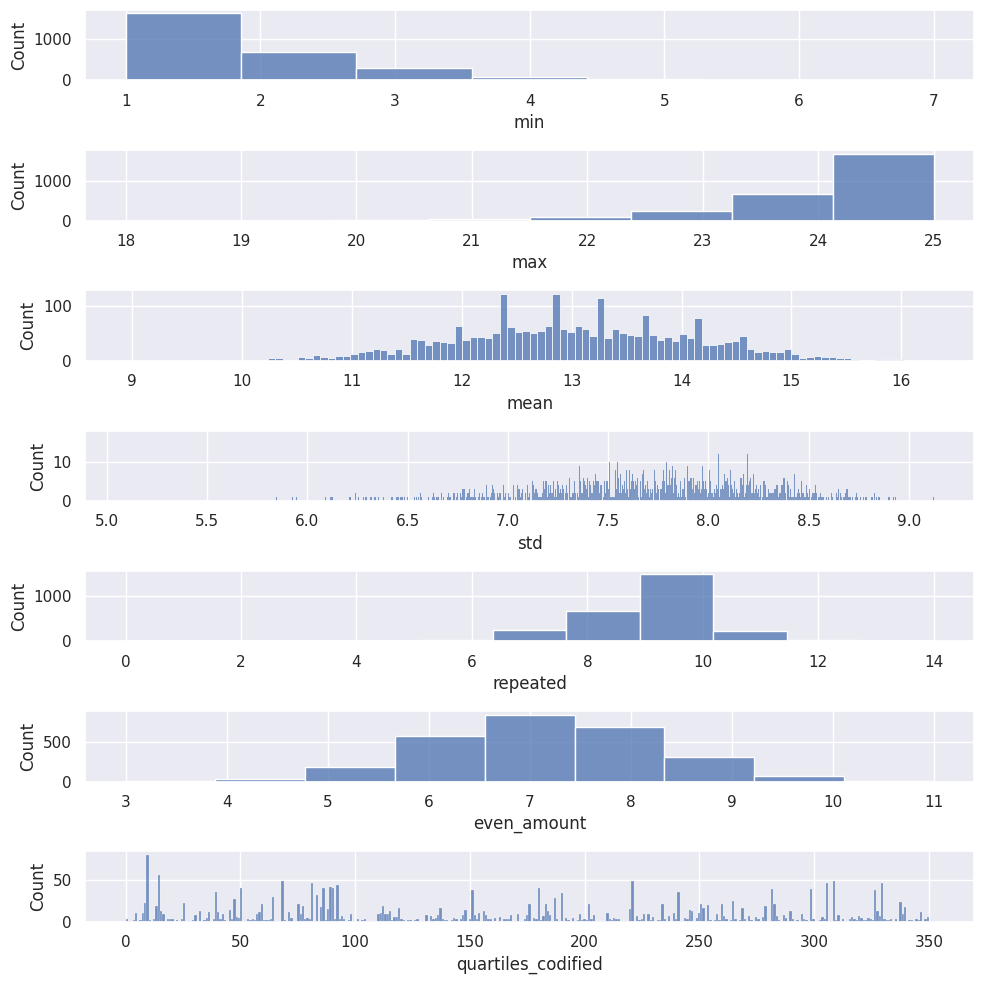

time: 13.2 s (started: 2023-07-24 14:33:38 +00:00)


In [91]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(7, 1, figsize=(10, 10))
for axis, col_name in zip(ax.ravel(), dataset.columns):
  sns.histplot(data=dataset, x=col_name, bins=dataset[col_name].nunique(), ax=axis)
plt.tight_layout()
plt.show()

# Train/Test Split

In [92]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

time: 1.77 ms (started: 2023-07-24 14:33:51 +00:00)


In [93]:
'''
tss = TimeSeriesSplit(n_splits=2, test_size=200, gap=1)
folds = tss.split(dataset)

next(folds)
train_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior

train_set = dataset.iloc[train_indexes]
test_set  = dataset.iloc[test_indexes]
'''

'\ntss = TimeSeriesSplit(n_splits=2, test_size=200, gap=1)\nfolds = tss.split(dataset)\n\nnext(folds)\ntrain_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior\n\ntrain_set = dataset.iloc[train_indexes]\ntest_set  = dataset.iloc[test_indexes]\n'

time: 4.42 ms (started: 2023-07-24 14:33:51 +00:00)


In [94]:
'''
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.lineplot(x=train_set.index, y=train_set['even_amount'], ax=axs)
sns.lineplot(x=test_set.index, y=test_set['even_amount'], ax=axs)

plt.tight_layout()
plt.show()
'''

"\nfig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)\n\naxs.axvline(test_set.index.min(), color='black', ls='--')\nsns.lineplot(x=train_set.index, y=train_set['even_amount'], ax=axs)\nsns.lineplot(x=test_set.index, y=test_set['even_amount'], ax=axs)\n\nplt.tight_layout()\nplt.show()\n"

time: 4.75 ms (started: 2023-07-24 14:33:51 +00:00)
